In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import sklearn.preprocessing

In [4]:
device = 'cuda'
train_size = 90 
lookback_size = 96
epochs = 500
learning_rate = 0.001
hidden_size = 1024

In [5]:
#create model
class SimpleLinear(torch.nn.Module):
    def __init__(self,input_size, hidden_size, device='cpu'):
        super(SimpleLinear, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.device = device
        self.linear1 = torch.nn.Linear(self.input_size, 1, device=self.device).double()

    def forward(self,x):
        x = self.linear1(x)
        return x

In [6]:
#prepare data
df = pd.read_csv("cgm_data.csv").sample(frac=1) #shuffle data rows (patients)
for column in df.columns:
    df[column] = df[column].astype(float) #convert columns into floats
ptids = df["ptid"]
df = df.drop("ptid",axis=1)

train_df = df.iloc[1:train_size,:]
test_df =  df.iloc[train_size:,:]

mean = train_df.mean(axis=None)
std = train_df.values.std(axis=None)

train_x = []
train_y = []
test_x = []
test_y = []
for i in range(len(df.columns)-lookback_size):
    train_x.append(((train_df.iloc[:,i:i+lookback_size].values - mean)/std))
    train_y.append(train_df.iloc[:,i+lookback_size].values)
    test_x.append(((test_df.iloc[:,i:i+lookback_size].values - mean)/std))
    test_y.append(test_df.iloc[:,i+lookback_size].values)

train_x = torch.from_numpy(np.array(train_x)).to(device) # [batch,patient id,sequence]
train_y = torch.from_numpy(np.array(train_y)).to(device) # [batch,patient id]
test_x = torch.from_numpy(np.array(test_x)).to(device)
test_y = torch.from_numpy(np.array(test_y)).to(device)

In [7]:
#instantiate model
model = SimpleLinear(input_size=lookback_size,hidden_size = hidden_size,device=device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
#train and test model
losses = []
test_losses = []
for i in tqdm(range(epochs)):
    
    for j in range(0,train_x.shape[0]):
        batch_x = train_x[j,:,:]
        batch_y = train_y[j,:]
        
        model.zero_grad()
        out = model(batch_x)
        loss = criterion(out,batch_y)
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    
    with torch.no_grad():
        pred = model(torch.reshape(test_x, [-1,lookback_size]))
        loss = criterion(pred, torch.reshape(test_y,[-1]))
        test_losses.append(loss.item())
        

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]C:\Users\Hamza\anaconda\envs\ass4\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([89])) that is different to the input size (torch.Size([89, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Hamza\anaconda\envs\ass4\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2688])) that is different to the input size (torch.Size([2688, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:58<00:00,  4.23it/s]


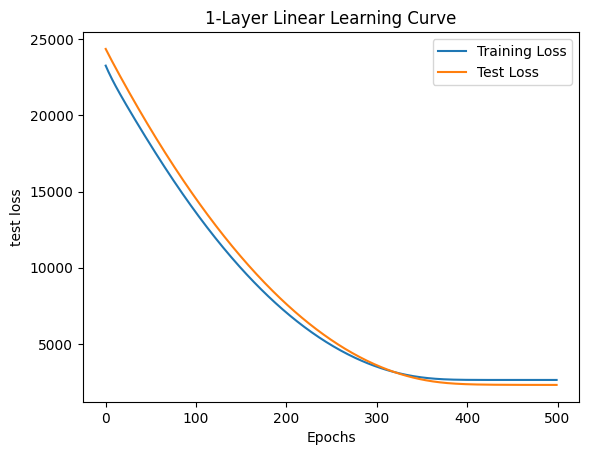

In [9]:
#Training Curve
plt.figure()
plt.plot(range(len(losses)), losses, label = "Training Loss")
plt.plot(range(len(test_losses)), test_losses, label = "Test Loss")
plt.ylabel("test loss")
plt.xlabel("Epochs")
plt.title("1-Layer Linear Learning Curve")
plt.legend()
plt.show()

In [10]:
predicted = np.reshape(pred.to("cpu"),[480-lookback_size,7])

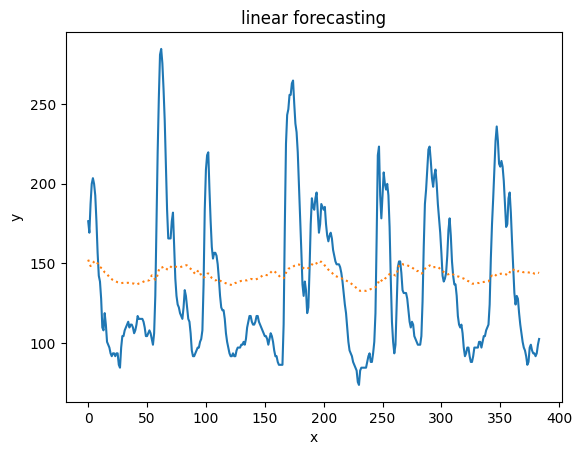

In [12]:
plt.figure()
plt.title("linear forecasting")
plt.xlabel("x")
plt.ylabel("y")
plt.xticks()
plt.yticks()
plt.plot(np.arange(test_y.shape[0]), test_y.to("cpu")[:,2])
plt.plot(np.arange(test_y.shape[0]), predicted[:,2], ":")
plt.show()